Script to dowload other data:
- terrain: DEM
- features: aerialways (teleferica, impianti a fune..)
- hiking trails

In [31]:
import requests
import geopandas as gpd
import os
import zipfile
import shapely
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import overpass
from owslib.wcs import WebCoverageService
from pyproj import Proj, transform
import rasterio
import rasterio.mask
import numpy as np
import geojson
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

In [32]:
# Same as water_download.ipynb
def download_and_unzip_shapefile(url, extract_to='../data/', download=True):

    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    if download:
        # Download the file
        local_zip_file = os.path.join(extract_to, 'shapefile.zip')
        with requests.get(url, stream=True) as r:
            with open(local_zip_file, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    
    elif not download:
        local_zip_file = url
        
    # Extract the file
    with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    os.remove(local_zip_file)
    
    # Return the path to the directory containing the shapefiles
    return print(f'Shapefile ready in {extract_to}')

# Confini Provincia
Source: https://siat.provincia.tn.it/geonetwork/srv/ita/catalog.search#/metadata/p_TN:377793f1-1094-4e81-810e-403897418b23

Will be used to clip other datasets.

In [3]:
provincia_url = 'https://siatservices.provincia.tn.it/idt/vector/p_TN_377793f1-1094-4e81-810e-403897418b23.zip'
download_and_unzip_shapefile(provincia_url, extract_to='../data/clip/')

Shapefile ready in ../data/clip/


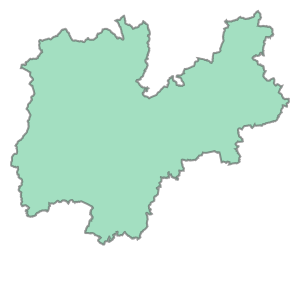

In [4]:
provincia = gpd.read_file('../data/clip/ammprv_v.shp')
provincia.geometry[0]

In [5]:
provincia.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- [east]: Easting (Meter)
- [north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS_1980
- Prime Meridian: Greenwich

# Terrain Data
Source: https://tinitaly.pi.ingv.it/wcs_service.html (original res: 10x10m)
- DEM
- Hillshade
- Slope

Functions

In [72]:
def tinitaly_request_stream(
    bbox_utm: list,
    width: int,
    height: int,
    resolution: int,
    coverage_id='TINItaly_1_1:tinitaly_dem',
    destination='../data/terrain/',
    crs='EPSG:32632'):

    ''' Function to perform request to Tinitaly's WCS in stream '''

    wcs_url = 'http://tinitaly.pi.ingv.it/TINItaly_1_1/wcs'

    params = {
        'service': 'WCS',
        'request': 'GetCoverage',
        'version': '1.0.0',
        'coverage': coverage_id,
        'bbox': ','.join(map(str, bbox_utm)),
        'crs': crs,
        'format': 'GeoTIFF',
        'width': width,
        'height': height
    }

    print(f"Requesting coverage {coverage_id} with resolution {resolution}...")

    # Send the request and stream the response
    response = requests.get(wcs_url, params=params, stream=True)
    print(f"Request completed with status code {response.status_code}")

    # Check if the request was successful
    if response.status_code == 200:
        # Save the response content to a file
        if not os.path.exists(destination):
            os.makedirs(destination)
        output_file = os.path.join(destination, coverage_id.split(':')[-1] + f'{resolution}m.tif')

        # Get the total length of the content
        total_size = int(response.headers.get('content-length', 0))

        print(f"Downloading data...")
        # Write the content to the file with a progress bar
        with open(output_file, 'wb') as file, tqdm(
            desc=f"Downloading {coverage_id}",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
            #bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}] {percentage:3.0f}%',
        ) as bar:
            for data in response.iter_content(chunk_size=16384): #1024
                file.write(data)
                bar.update(len(data))

        print(f"Coverage saved to {output_file}")
        return output_file
    else:
        print(f"Error: {response.status_code}")
        return None

In [49]:
def clip_raster(
    raster_path, 
    prov_path='../data/clip/ammprv_v.shp',
    destination='../data/terrain/'):

    ''' Function to clip a raster with a polygon '''

    with rasterio.open(raster_path) as src:
        dem_data = src.read(1)  # Read the first band
        dem_transform = src.transform  # Get the transform
        dem_crs = src.crs  # Get the CRS
        dem_nodata = src.nodata

    # Read the polygon
    provincia = gpd.read_file(prov_path)
    polygon = provincia['geometry'][0]   

    # Convert polygon to GeoJSON-like mapping
    polygon_geom = [mapping(polygon)]

    # Mask the DEM with the polygon
    with rasterio.open(raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, polygon_geom, crop=True)
        out_meta = src.meta.copy()

    # Update the metadata to reflect the new dimensions and transform
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": dem_nodata
    })

    with rasterio.open(raster_path, "w", **out_meta) as dest:
        dest.write(out_image)

    print(f"Raster clipped successfully and saved at {raster_path}")
    return raster_path 

In [50]:
def plot_clipped_raster(raster_path, resolution):

    ''' Function to plot the clipped raster '''
    with rasterio.open(raster_path) as src:
        # Read the first band of the dataset
        dem_data = src.read(1)
        dem_nodata = src.nodata

    # Create a masked array for plotting
    clipped_dem_masked = np.ma.masked_equal(dem_data, dem_nodata)

    titles = {'dem': 'Digital Elevation Model (DEM)',
              'hshd': 'Hillshade',
              'slope': 'Slope'}

    labels = {'dem': 'Elevation [m]',
              'hshd': 'Brightness',
              'slope': 'Slope [degrees]'}
    obj = os.path.basename(raster_path).split('_')[-1].split('.')[0][:-3] # remove last 3 (res)

    plt.imshow(clipped_dem_masked, cmap='binary')
    plt.colorbar(label=labels[obj], shrink=0.75)
    plt.title(titles[obj] + f"(res. {resolution}m)")
    plt.show()

Request parameters: bounding box & resolution

In [37]:
bbox_4326 = (10.46750857, 45.69873184, 11.94937569, 46.53633029) # TRENTINO
# Desired resolution (meters)
desired_resolution = 10 # 10m is the original res

# Define the source and destination CRS
src_crs = Proj(init='epsg:4326')  # WGS84 (deg)
dst_crs = Proj(init='epsg:32632')  # UTM zone 32N (meters)
# Transform the bounding box coordinates to UTM
xmin, ymin = transform(src_crs, dst_crs, bbox_4326[0], bbox_4326[1])
xmax, ymax = transform(src_crs, dst_crs, bbox_4326[2], bbox_4326[3])
bbox_utm = (xmin, ymin, xmax, ymax)

print(f"Transformed bounding box in UTM: {bbox_utm}")

# Calculate width and height in pixels
width = int((xmax - xmin) / desired_resolution)
height = int((ymax - ymin) / desired_resolution)
print(f"RES: {desired_resolution}m, Width in pixels: {width}, Height in pixels: {height}")

Transformed bounding box in UTM: (614247.4307366736, 5061622.641956749, 726155.1390219606, 5157866.9110916145)
RES: 10m, Width in pixels: 11190, Height in pixels: 9624


In [38]:
# URL of the WCS service capabilities
wcs_getCapabilities_url = 'http://tinitaly.pi.ingv.it/TINItaly_1_1/wcs?service=WCS&request=getCapabilities'
# Connect to the WCS
wcs = WebCoverageService(wcs_getCapabilities_url, version='1.0.0')
wcs.contents

{'TINItaly_1_1:tinitaly_dem': <owslib.coverage.wcs100.ContentMetadata at 0x12cbdf940>,
 'TINItaly_1_1:tinitaly_hsv': <owslib.coverage.wcs100.ContentMetadata at 0x12cbdc9d0>,
 'TINItaly_1_1:tinitaly_hshd': <owslib.coverage.wcs100.ContentMetadata at 0x12cbdc970>,
 'TINItaly_1_1:tinitaly_od': <owslib.coverage.wcs100.ContentMetadata at 0x12cbdeec0>,
 'TINItaly_1_1:tinitaly_svf_2d5': <owslib.coverage.wcs100.ContentMetadata at 0x12cbde710>,
 'TINItaly_1_1:tinitaly_svf_ea': <owslib.coverage.wcs100.ContentMetadata at 0x12cbdf730>,
 'TINItaly_1_1:tinitaly_slope': <owslib.coverage.wcs100.ContentMetadata at 0x12cbdf760>,
 'TINItaly_1_1:tinitaly_slope_2d5': <owslib.coverage.wcs100.ContentMetadata at 0x12cbdef80>}

## DEM
NB: with the original resolution (10m) these are large files (~450MB). Only download what is needed.

Requesting coverage TINItaly_1_1:tinitaly_dem with resolution 10...
Request completed with status code 200


Coverage saved to ../data/terrain/tinitaly_dem10m.tif
Raster clipped successfully and saved at ../data/terrain/tinitaly_dem10m.tif


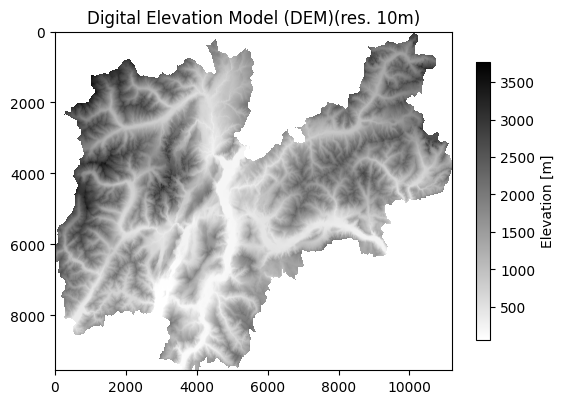

In [74]:
dem_path = tinitaly_request_stream(bbox_utm, width, height, desired_resolution)
dem_clip_path = clip_raster(raster_path=dem_path)
plot_clipped_raster(dem_clip_path, desired_resolution)

## Hillshade

Requesting coverage TINItaly_1_1:tinitaly_hshd with resolution 10...
Request completed with status code 200


Coverage saved to ../data/terrain/tinitaly_hshd10m.tif
Raster clipped successfully and saved at ../data/terrain/tinitaly_hshd10m.tif


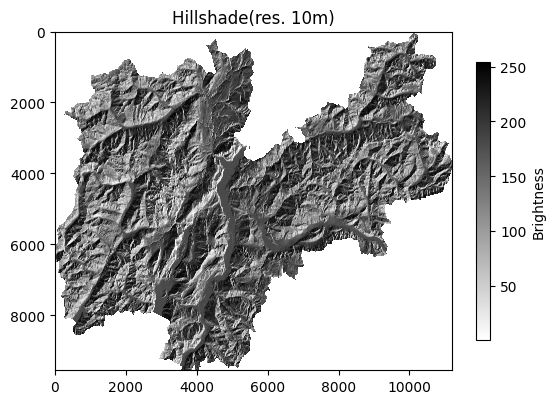

In [76]:
hshd_path = tinitaly_request_stream(bbox_utm, width, height, desired_resolution, coverage_id='TINItaly_1_1:tinitaly_hshd')
hshd_clip_path = clip_raster(raster_path=hshd_path)
plot_clipped_raster(hshd_clip_path, desired_resolution)

## Slope

In [ ]:
slope_path = tinitaly_request_stream(bbox_utm, width, height, desired_resolution, coverage_id='TINItaly_1_1:tinitaly_slope')
slope_clip_path = clip_raster(raster_path=slope_path)
plot_clipped_raster(slope_clip_path, desired_resolution)

# Hiking trails
Source: SIAT 'tracciati alpini' https://siat.provincia.tn.it/geonetwork/srv/ita/catalog.search#/metadata/p_TN:f3547bc8-bf1e-4731-85d2-2084d1f4ba07

In [25]:
# access point
sentieri_url = 'https://siatservices.provincia.tn.it/idt/vector/p_TN_f3547bc8-bf1e-4731-85d2-2084d1f4ba07.zip'
download_and_unzip_shapefile(sentieri_url, extract_to='../data/trails/')

# Rename files to remove spaces
for root, dirs, files in os.walk('../data/trails/'):
    for file in files:
        if ' ' in file:
            new_file_name = file.replace(' ', '_')
            os.rename(os.path.join(root, file), os.path.join(root, new_file_name))

Shapefile ready in ../data/trails/


In [59]:
trails_gdf = gpd.read_file('../data/trails/Sentieri_della_SAT.shp')
trails_gdf.head(5)

,numero,classid,dataagg,gr_mont,datafine,loc_fine,objectid,t_andata,denominaz,quota_max,...,t_ritorno,competenza,comuni_toc,difficolta,loc_inizio,lun_inclin,lun_planim,quota_fine,quota_iniz,geometry
0,E106,tur006_E106,2021/01/01 00:00:00.000,MONTI LESSINI,None,MALGA LAVACCHIONE,31538,03:45:00.000,None,1408,...,02:45:00.000,SEZ. SAT ALA,ALA,E,VAL FREDDA,6710,6510,1402,301,"LINESTRING (653619.72 5066118.31, 653633.57 50..."
1,E176,tur006_E176,2021/01/01 00:00:00.000,CAREGA - PICCOLE DOLOMITI,None,PASSO DEGLI ONARI - bivio 149-CAI,31539,00:40:00.000,VF - EEA-F,1761,...,00:30:00.000,SEZ. SAT VALLARSA,VALLARSA,EEA-F,pr: SELLETTA NO,1160,900,1759,1586,"LINESTRING (668794.25 5068464.05, 668794.03 50..."
2,E101,tur006_E101,2021/01/01 00:00:00.000,PASUBIO - COLSANTO,None,"RIFUGIO ""VINCENZO LANCIA""",31540,02:40:00.000,None,1800,...,02:00:00.000,"SEZ. SAT ROVERETO, RIF. ALPE POZZA ""VINCENZO L...",TRAMBILENO,E,GIAZZERA,6470,6420,1800,1092,"LINESTRING (662888.22 5080025.22, 662893.92 50..."
3,E105B,tur006_E105B,2021/01/01 00:00:00.000,PASUBIO - COLSANTO,None,SELLETTA DEL GROVIGLIO,31541,00:10:00.000,None,2127,...,00:10:00.000,"RIF. ALPE POZZA ""VINCENZO LANCIA""",TRAMBILENO,E,SELLA AL PICCOLO ROITE,220,210,2082,2127,"LINESTRING (669203.29 5074070.41, 669213.78 50..."
4,E103,tur006_E103,2021/01/01 00:00:00.000,FINONCHIO - MONTE MAGGIO,None,ZOM - Pr� del Finonchio,31542,02:00:00.000,None,1576,...,01:30:00.000,SEZ. SAT ROVERETO,ROVERETO,E,MOIETTO,4020,3940,1576,923,"LINESTRING (661850.95 5084590.91, 661865.34 50..."


In [ ]:
trails_gdf.columns

In [ ]:
trails_gdf.difficolta.unique()

Difficoltà:
- E: Escursionistico
- EE: Escursionisti Esperti
- EEA-D: Escursionisti Esperti con Attrezzatura alpinistica - Difficile
- EEA-F: Escursionisti Esperti con Attrezzatura alpinistica - Facile
- EEA-MD: Escursionisti Esperti con Attrezzatura alpinistica - Molto Difficile
- EEA-PD: Escursionisti Esperti con Attrezzatura alpinistica - Poco Difficile
- T: Turistico

(https://www.sat.tn.it/sentieri/scala-difficolta/)

<Axes: >

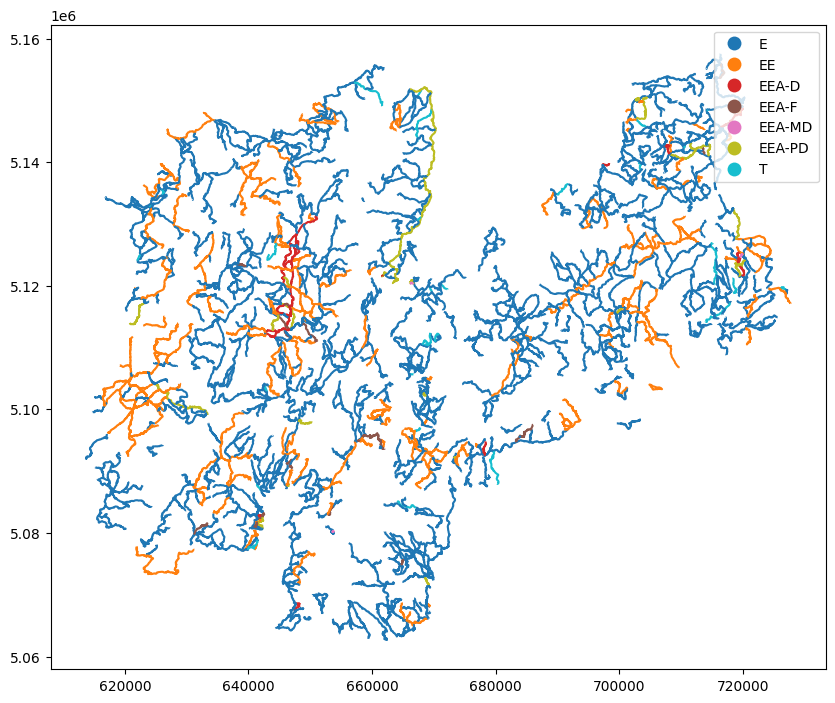

In [28]:
trails_gdf.plot(column='difficolta', legend=True, figsize=(10, 10))

In [61]:
trails_gdf.to_crs(epsg=4326, inplace=True)
trails_gdf.to_file('../data/trails/Sentieri_della_SAT_4326.geojson', driver='GeoJSON')

# Aerialways & lifts

In [54]:
# Overpass API query
query = f"""
nwr["aerialway"]({bbox_4326[1]},{bbox_4326[0]},{bbox_4326[3]},{bbox_4326[2]});
out geom;
"""

# Create an Overpass API instance
api = overpass.API()
response = api.get(query)

# Filter out features with empty geometries
filtered_features = [feature for feature in response['features'] if feature['geometry']['coordinates']]

# Extract id, geometry, and tags
data = []
for feature in filtered_features:
    feature_id = feature['properties']['id']
    geometry = shapely.geometry.shape(feature['geometry'])
    tags = feature['properties']['tags']
    tags['id'] = feature_id  # Add id to tags
    tags['geometry'] = geometry  # Add geometry to tags
    data.append(tags)

# Convert the DataFrame to a GeoDataFrame
aerialways_gdf = gpd.GeoDataFrame(data, geometry='geometry', crs='EPSG:4326')

aerialways_gdf.aerialway.unique()

array(['station', 'pylon', 'yes', 'platter', 'cable_car', 'chair_lift',
       'gondola', 'mixed_lift', 'drag_lift', 'magic_carpet', 'goods',
       'zip_line', 'rope_tow'], dtype=object)

In [55]:
# Filter for goods-aerialway (teleferica) and lifts (impianti a fune)
goods_aerialways = aerialways_gdf[aerialways_gdf['aerialway'] == 'goods']

lifts_tags = ['station', 'cable_car', 'chair_lift', 'gondola', 'mixed_lift']
lifts = aerialways_gdf[aerialways_gdf['aerialway'].isin(lifts_tags)]

# Clip on Trentino boundaries
provincia4326 = provincia.to_crs(lifts.crs)
goods_aerialways = gpd.clip(goods_aerialways, provincia4326)
lifts = gpd.clip(lifts, provincia4326)

<Axes: >

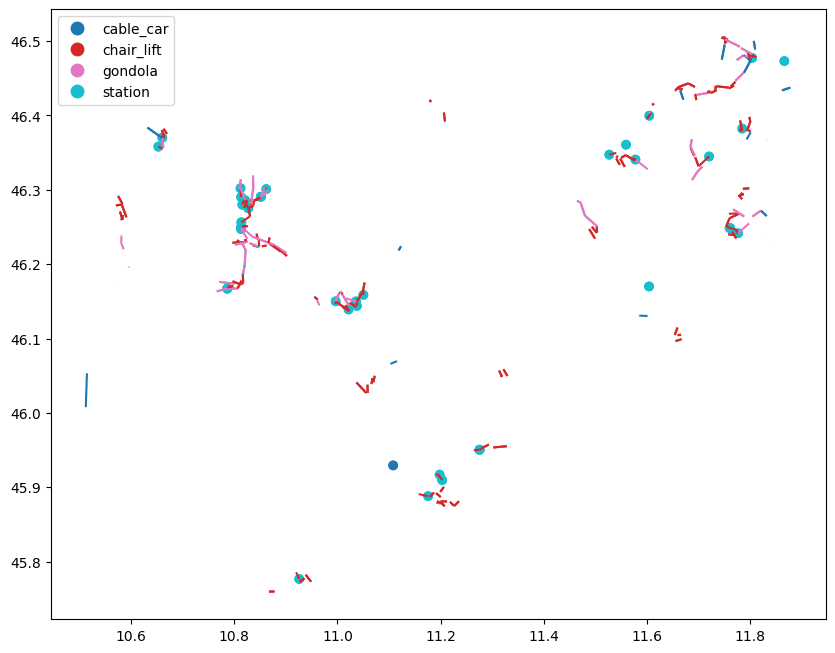

In [56]:
lifts.plot(column='aerialway', legend=True, figsize=(10, 10))

<Axes: >

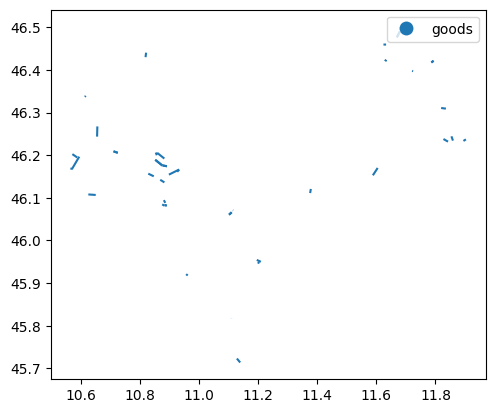

In [57]:
# Remove empty geometries
goods_aerialways = goods_aerialways[~goods_aerialways.is_empty]
goods_aerialways.plot(column='aerialway', legend=True)

In [58]:
# Save 
destination = '../data/others/'
os.makedirs(destination, exist_ok=True)

goods_aerialways.to_file(destination + 'goods_aerialways.geojson', driver='GeoJSON')
lifts.to_file(destination + 'lifts_aerialways.geojson', driver='GeoJSON')
